In [1]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
from libpysal.graph import read_parquet, Graph
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import preprocess_clustering_data
from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
from scipy.cluster.hierarchy import fcluster

In [2]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_100_0_None_None_False'
clip = None
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe'
]
linkage = 'ward'
metric = 'euclidean'

In [3]:
def preprocess_data(data):
    component_data = data.drop(columns=['percentile_25', 'percentile_75', 'median', 'std'], level=1)
    component_data = component_data.drop(columns=to_drop, level=0)
    component_data.columns =  component_data.columns.get_level_values(0)
    
    component_data = component_data[component_data.index.str[-2:] != '-1']
    
    vals = StandardScaler().fit_transform(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)
    
    # component_data = component_data[component_data.index >= 0]
    vals = np.nan_to_num(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    return component_data

def read_region_morphotope_data(region_id):
    print('processing' , region_id)
    data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
    data.index = str(region_id) + '_' + data.index
    data = data.iloc[:, :-1]
    component_data = preprocess_data(data)

    return component_data

def get_morphotope_linkage(region_data):
    
    clusterer = AgglomerativeClustering(linkage=linkage,
                                        metric=metric,
                                        compute_full_tree=True,
                                        compute_distances=True)
    model = clusterer.fit(region_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix


def get_all_clusters(cutoff):
    region_hulls = gpd.read_parquet(
            regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
    )
    
    all_clusters = []
    
    for region_id, _ in region_hulls.iterrows():
        data = read_region_morphotope_data(region_id)
        region_index = data.index
        linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}.npy')
        clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
        clusters = pd.Series(clusters, region_index).astype(str)
        clusters = str(region_id) + '_' +clusters
        all_clusters.append(clusters)
    
    all_clusters = pd.concat(all_clusters)
    
    return all_clusters


def read_morphotopes_data(model_params):

    ### primary chars
    region_hulls = gpd.read_parquet(
            regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
    )
    
    data = []
    for region_id, _ in region_hulls.iterrows():
        region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
        region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
        data.append(region_morphotope_data)
    
    data = pd.concat(data)
    return data

def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):


    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')
        
    etcs['label'] = -1
    
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [4]:
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

In [79]:
region_hulls.explore()

In [6]:
### generate and save linkage matricies for each region

# %%time
# for region_id, _ in region_hulls.iterrows():
#     data = read_region_morphotope_data(region_id)
#     linkage_matrix = get_morphotope_linkage(data)
#     np.save(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}', linkage_matrix)

### Setup regional cutoff to merge regional morphotopes

In [7]:
regional_cutoff = 20

In [8]:
regional_clusters = get_all_clusters(cutoff=regional_cutoff)

processing 4
processing 10
processing 132
processing 134
processing 286
processing 313
processing 400
processing 523
processing 765
processing 801
processing 832
processing 913
processing 960
processing 1124
processing 1154
processing 1387
processing 1478
processing 1515
processing 1605
processing 1718
processing 1736
processing 1782
processing 1970
processing 1981
processing 2096
processing 2322
processing 2350
processing 2478
processing 2514
processing 2625
processing 2728
processing 2975
processing 3039
processing 3109
processing 3150
processing 3221
processing 3250
processing 3526
processing 3610
processing 3612
processing 3701
processing 3705
processing 3752
processing 3759
processing 3981
processing 4070
processing 4214
processing 4215
processing 4235
processing 4284
processing 4356
processing 4382
processing 4723
processing 4805
processing 5096
processing 5191
processing 5246
processing 5310
processing 5408
processing 5427
processing 5662
processing 5671
processing 5766
processi

In [9]:
%%time
morphotopes_data = read_morphotopes_data(model_params)

CPU times: user 20 s, sys: 5.99 s, total: 26 s
Wall time: 11.7 s


In [10]:
morphotopes_data = morphotopes_data.loc[regional_clusters.index]
regional_ward_morphotopes_data = morphotopes_data.groupby(regional_clusters).mean()
regional_ward_morphotopes_data = regional_ward_morphotopes_data.iloc[:, :-1]
regional_ward_morphotopes_data

sdbAre                                                    \
        percentile_25      median percentile_75         std        mean   
10019_1     34.536730  114.068308    278.934558  650.286045  282.583524   
10019_2     30.883804   63.774971     98.082417  118.270604   86.344882   
10019_3     50.598924   82.293761    131.969295  105.118231  109.614812   
10019_4     36.518561   67.753131    101.979863   68.609528   80.161853   
10019_5     27.481523   53.508844     85.153879   47.915400   61.898621   
...               ...         ...           ...         ...         ...   
99886_5     95.596808  267.806174    554.471447  615.310948  442.940138   
99886_6     71.697345  153.279637    268.781231  201.388804  206.603629   
99886_7     91.632803  199.029520    418.219510  425.441030  331.467639   
99886_8    126.632340  229.324058    393.981760  236.712805  292.266066   
99886_9     77.360938  141.963827    214.508235  254.356927  193.125175   

               sdbPer                                                 ...  \
        percentile_25     median percentile_75        std       mean  ...   
10019_1     25.312069  48.141677     77.322486  50.642453  60.643572  ...   
10019_2     23.746705  34.429539     43.927445  19.900002  36.490578  ...   
10019_3     30.607161  39.419854     50.402463  22.647987  43.887531  ...   
10019_4     25.973667  35.517353     46.121608  18.817697  38.196474  ...   
10019_5     22.425619  31.399784     39.227095  14.344752  32.352298  ...   
...               ...        ...           ...        ...        ...  ...   
99886_5     41.766585  73.921126    114.849461  64.424965  87.911153  ...   
99886_6     37.332438  56.601564     85.713352  43.389526  67.518114  ...   
99886_7     42.386874  67.355284    101.837884  54.888611  80.118555  ...   
99886_8     47.073777  78.150717    118.100314  58.474686  91.897213  ...   
99886_9     40.098406  54.403883     74.415755  37.526020  63.355325  ...   

                mibFR                                              \
        percentile_25    median percentile_75       std      mean   
10019_1      2.598926  3.892183      5.491581  3.721435  4.680928   
10019_2      1.841299  2.354463      2.793675  0.866916  2.386156   
10019_3      3.341867  3.653477      4.095116  0.712386  3.687432   
10019_4      2.414012  2.752912      3.107820  0.688489  2.766476   
10019_5      2.028884  2.413209      2.799706  0.663114  2.414690   
...               ...       ...           ...       ...       ...   
99886_5      3.183112  4.803344      6.459835  2.904836  5.124597   
99886_6      3.438859  4.044486      4.721955  1.205909  4.078275   
99886_7      4.568383  5.637538      6.847343  2.202609  5.817028   
99886_8      4.452137  4.617901      4.657044  0.491905  4.584646   
99886_9      6.735074  6.735074      6.735074  0.906195  6.475901   

               mibSCo                                              
        percentile_25    median percentile_75       std      mean  
10019_1      2.598926  3.892183      5.491581  3.721435  4.680928  
10019_2      1.841299  2.354463      2.793675  0.866916  2.386156  
10019_3      3.341867  3.653477      4.095116  0.712386  3.687432  
10019_4      2.414012  2.752912      3.107820  0.688489  2.766476  
10019_5      2.028884  2.413209      2.799706  0.663114  2.414690  
...               ...       ...           ...       ...       ...  
99886_5      3.183112  4.803344      6.459835  2.904836  5.124597  
99886_6      3.438859  4.044486      4.721955  1.205909  4.078275  
99886_7      4.568383  5.637538      6.847343  2.202609  5.817028  
99886_8      4.452137  4.617901      4.657044  0.491905  4.584646  
99886_9      6.735074  6.735074      6.735074  0.906195  6.475901  

[13612 rows x 360 columns]

In [11]:
# region_id = 4
# data = read_region_morphotope_data(region_id)
# linkage_matrix = get_morphotope_linkage(data)

### Final ward clustering

In [49]:
final_cutoff = 100

In [50]:
linkage_matrix = get_morphotope_linkage(preprocess_data(regional_ward_morphotopes_data))

In [51]:
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
final_clusters.value_counts()

23    2121
24    1984
4     1802
22    1113
10    1046
2      900
3      660
18     644
5      618
19     593
21     501
11     361
26     320
17     279
8      254
1      113
20      95
15      89
16      62
25      42
14       6
13       4
12       2
9        1
6        1
7        1
Name: count, dtype: int64

### Plotting

In [116]:
region_id = 38679

In [117]:
# etcs=False to read buildings, etcs=True for tessellation cells.
etcs = morphotopes_to_etcs(region_id, etcs=False)

In [118]:
## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['final'] = etcs['morph'].map(lambda x: final_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)

In [119]:
etcs = etcs.to_crs(epsg=4326)
etcs['geometry'] = etcs.geometry.make_valid()

In [120]:
etcs = etcs[etcs['geometry'].geom_type == 'Polygon']

In [121]:
# def merge(block):
#     return shapely.GeometryCollection(block.geometry.values)

# mt_bds = etcs.groupby('morph')['geometry'].apply(merge).

In [122]:
# bound = mt_bds.set_crs(etcs.crs).concave_hull(0.5).boundary

In [123]:
# bound_layer= lonboard.PathLayer.from_geopandas(bound.to_frame('geometry'), width_min_pixels=0.8)

In [124]:
# # can run this to change colors on an exisitng layer
# layer.get_fill_color = get_color(etcs.morph.factorize()[0], (200, 200, 200))

In [125]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

CPU times: user 1.48 s, sys: 194 ms, total: 1.68 s
Wall time: 1.68 s


In [126]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatterNoLabels)
with sc:
    display(m)

In [127]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(etcs.final, (200,200,200))

In [128]:
bound_layer.get_color = [235, 233, 209]


In [ ]:
target_cluster = 96
etcs[etcs.final == target_cluster].shape

In [ ]:
# etcs[etcs.final == target_cluster].explore(prefer_canvas=True, tiles='Cartodb positron')

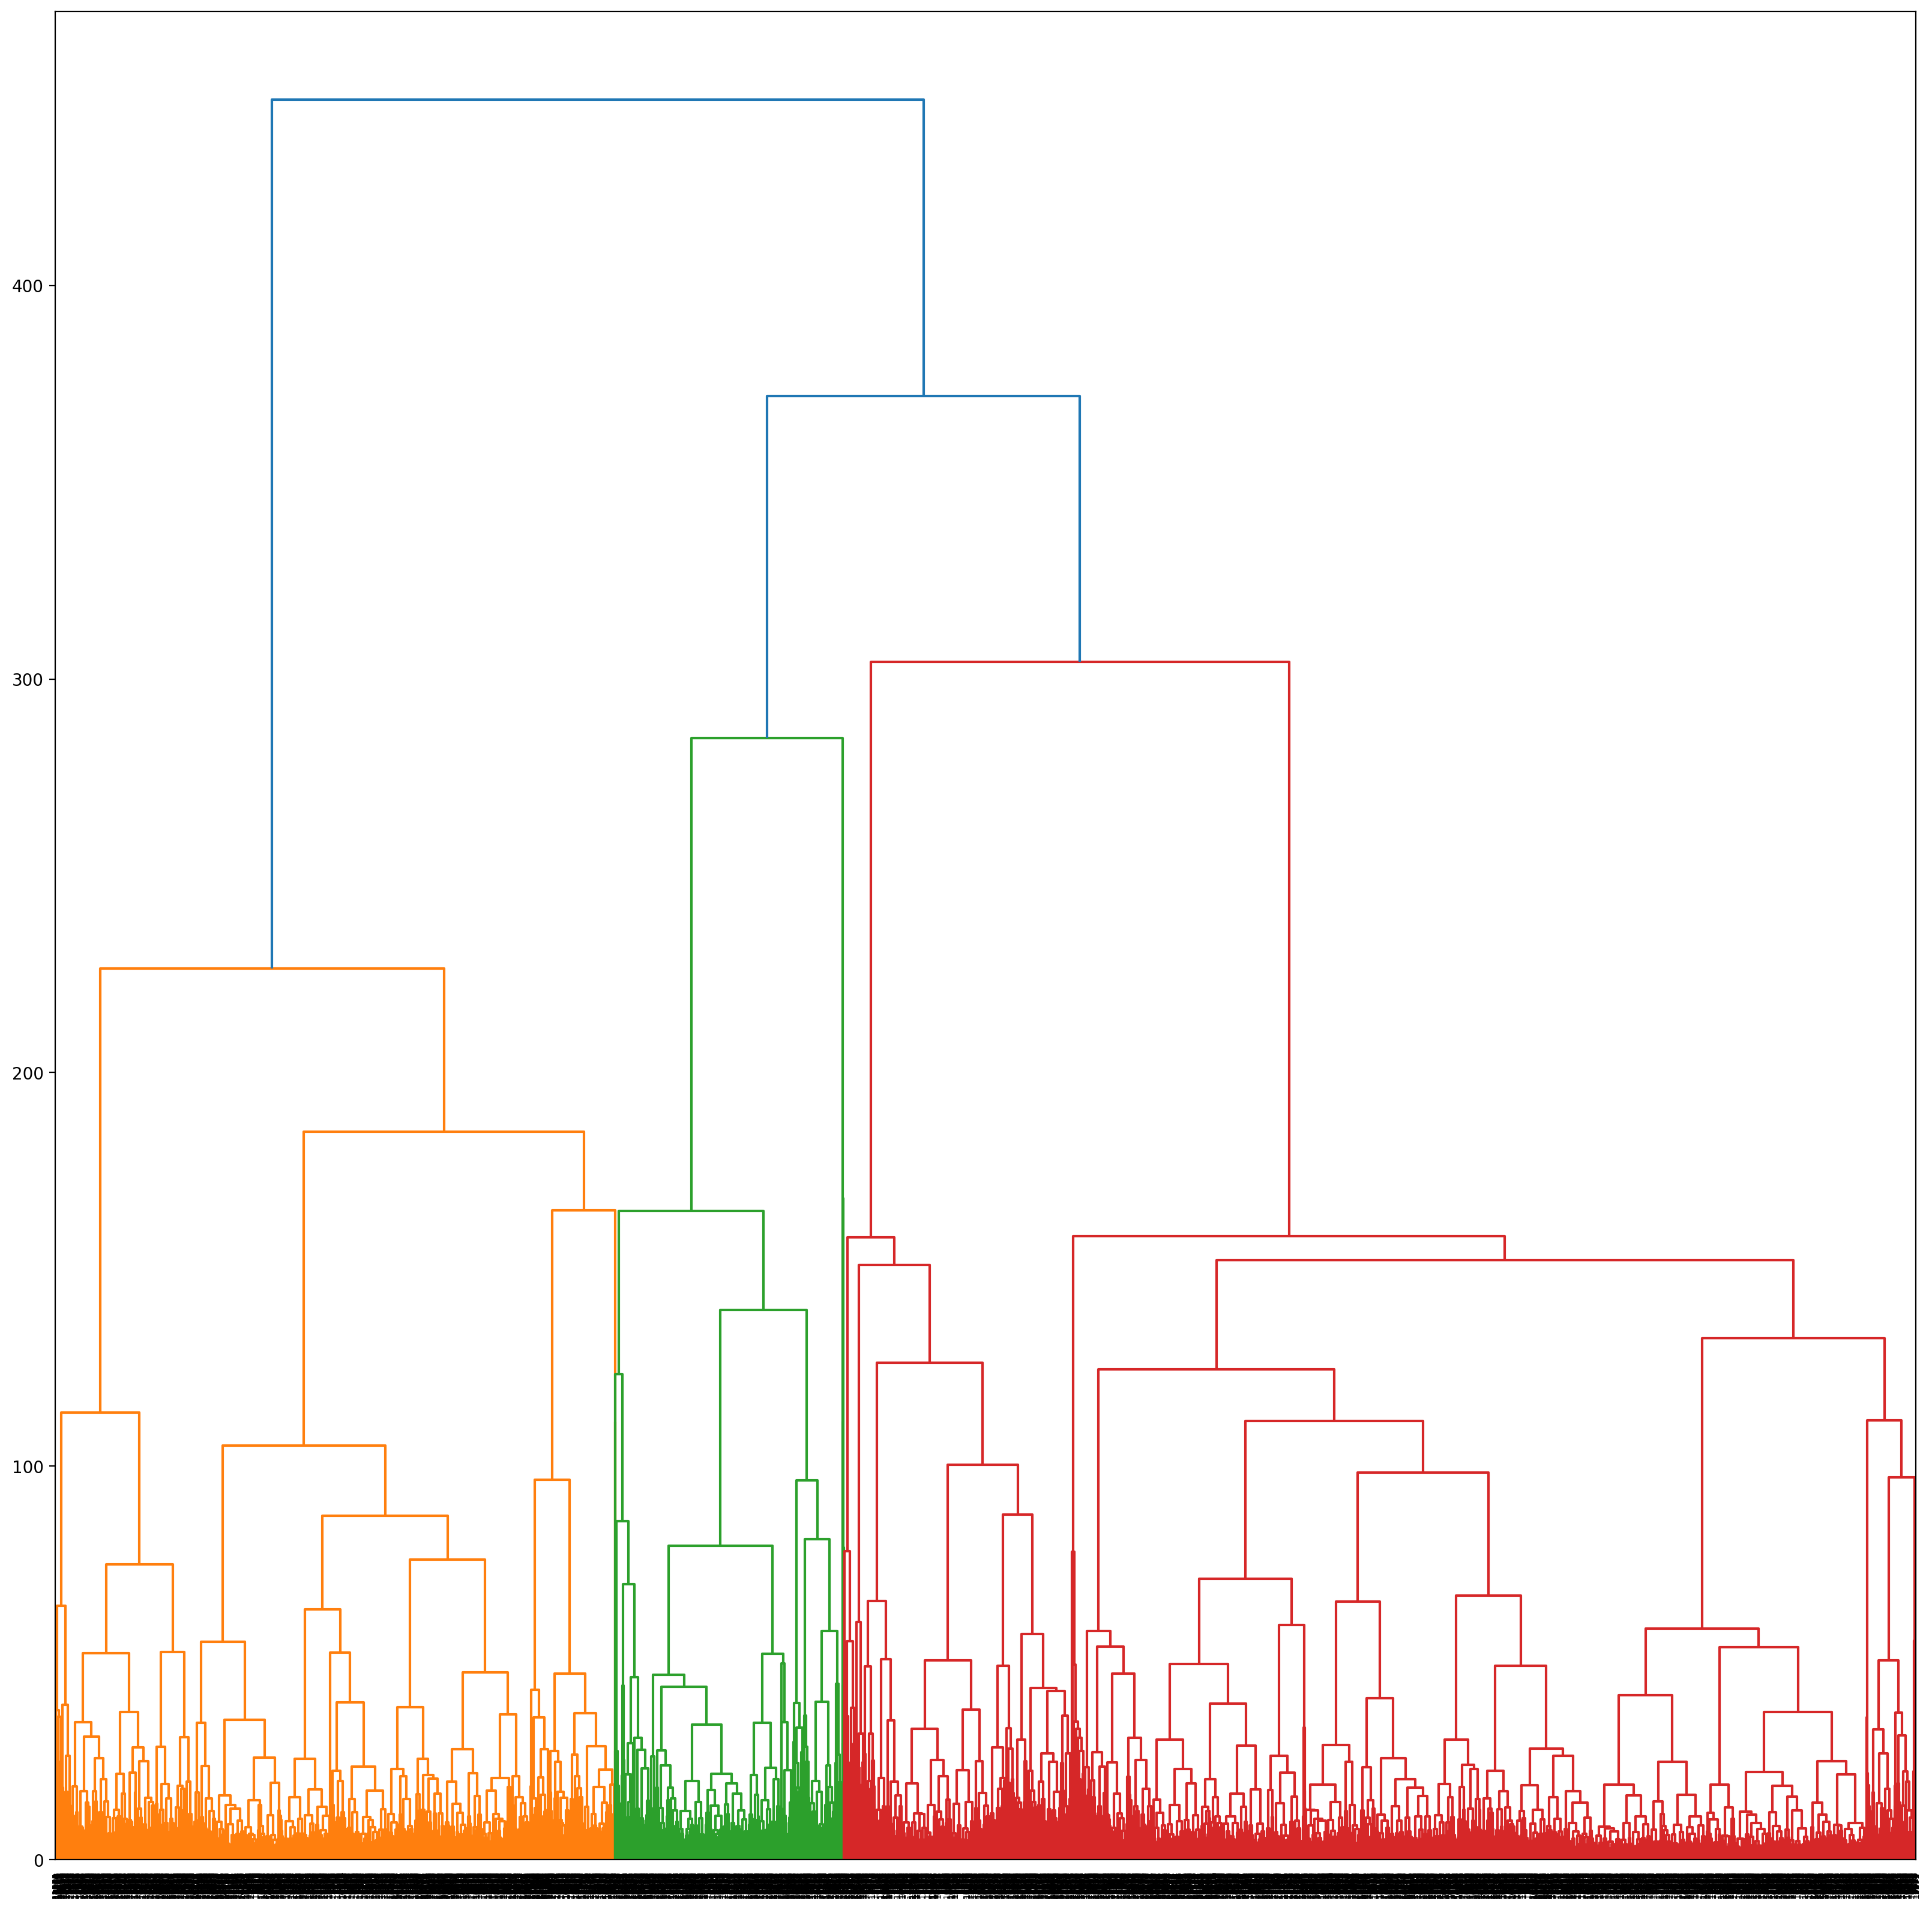

In [129]:
## final dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(20,20), dpi=200)
_ = dendrogram(linkage_matrix,ax=ax)

In [161]:
def smoothsegment(seg, Nsmooth=100):
    return np.concatenate([[seg[0]], np.linspace(seg[1], seg[2], Nsmooth), [seg[3]]])


def plot_dendrogram(icoord,dcoord,figsize, polar=False, log=True):
    if polar:
        if log:
            dcoord = -np.log(dcoord+1)
        else:
            dcoord = -(dcoord+1)
        # avoid a wedge over the radial labels
        gap = 0.1
        imax = icoord.max()
        imin = icoord.min()
        icoord = ((icoord - imin)/(imax - imin)*(1-gap) + gap/2)*2*np.pi

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, polar=polar)
    for xs, ys in zip(icoord, dcoord):
        if polar:
            xs = smoothsegment(xs)
            ys = smoothsegment(ys)
        ax.plot(xs,ys, color="black", linewidth=0.5)
    # ax.set_title(f"Polar= {polar}", fontsize=15)
    if polar:
        ax.spines['polar'].set_visible(False)
        ax.set_rlabel_position(0)
        Nxticks = 10
        xticks = np.linspace(gap/2, 1-gap/2, Nxticks)
        ax.set_xticks([])
        # ax.set_xticklabels(np.round(np.linspace(imin, imax, Nxticks)).astype(int))  


In [162]:
dg = _

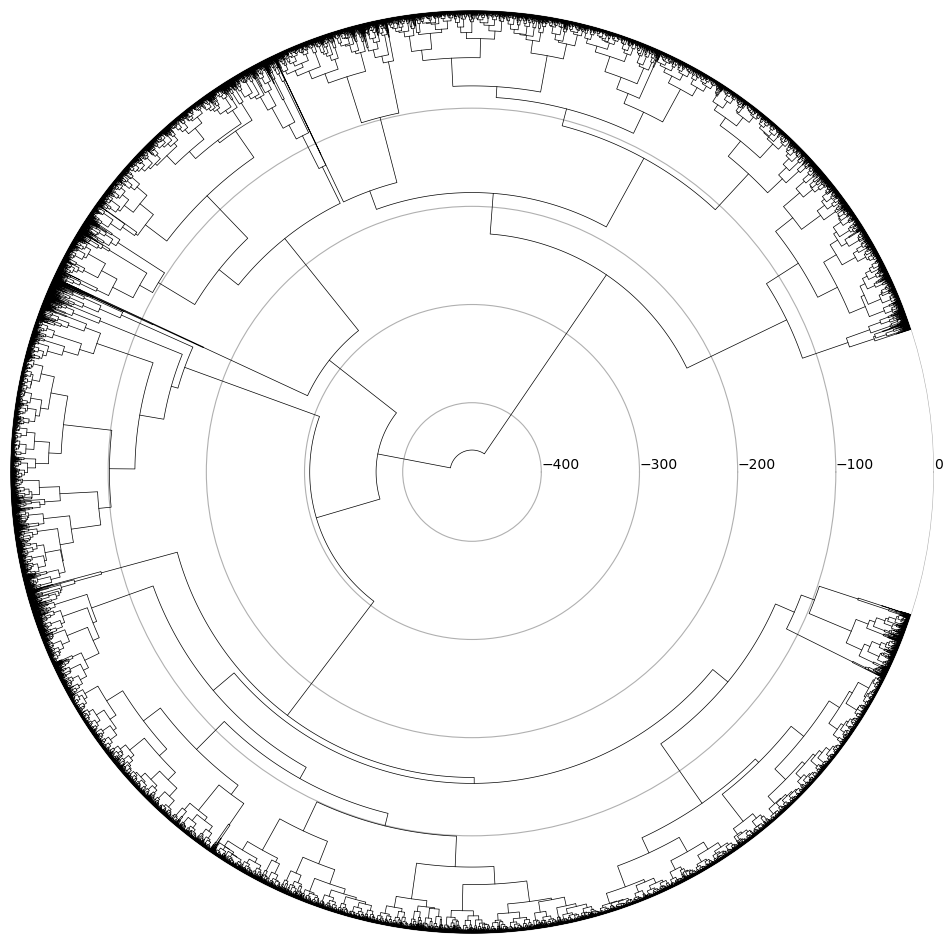

In [163]:
plot_dendrogram(np.array(dg['icoord']), np.array(dg['dcoord']), (12, 12), True, False)
for ext in ['png', 'pdf']:
    plt.savefig(f'dengro.{ext}', dpi=300)